In [1]:
%reload_kedro

2021-05-25 18:08:25,479 - kedro.framework.session.store - INFO - `read()` not implemented for `BaseSessionStore`. Assuming empty store.
2021-05-25 18:08:25,719 - root - INFO - ** Kedro project Foehn fire impact
2021-05-25 18:08:25,721 - root - INFO - Defined global variable `context`, `session` and `catalog`
2021-05-25 18:08:25,728 - root - INFO - Registered line magic `run_viz`


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import pandas as pd
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import scipy as sci
from utils import *
import kedro.framework.context
import json

plt.rcParams["figure.figsize"] = (16,9)
sns.set(font_scale=1.6)
sns.set_style("whitegrid")

In [4]:
df = context.catalog.load("fire_data_with_foehn_and_control_variables")

2021-05-25 18:08:28,039 - kedro.io.data_catalog - INFO - Loading data from `fire_data_with_foehn_and_control_variables` (CSVDataSet)...


In [5]:
df_foehn = context.catalog.load("foehn_data_prepared")

2021-05-25 18:08:28,133 - kedro.io.data_catalog - INFO - Loading data from `foehn_data_prepared` (CSVDataSet)...


In [19]:
df_foehn["year"] = df_foehn["date"].dt.year
df_foehn["month"] = df_foehn["date"].dt.month
df_foehn["day"] = df_foehn["date"].dt.day

In [38]:
regions = {"southern_switzerland": ["SBO", "LUG", "MAG", "OTL", "GRO", "CEV", "COM", "PIO", "VIO", "ROB", "SBE"],
           "wallis": ["VIS", "MVE", "SIO", "EVI", "AIG"],
           "east_switzerland": ["AND", "CHU", "RAG", "VAD"],
           "central_switzerland": ["INT", "MER", "ALT", "LUZ", "EIN"]}

In [86]:
print(r"\hline")
print(r"station & foehn presence [\%] & $\mathit{FFX}_{max}$ [km/h] & $\mathit{UU}_{min}$ [\%] \\")
print(r"\hline")

days_of_foehn = {}
for region, stations in regions.items():
    
    foehn_fraction = 0
    FFX_max = 0
    UU_min = 0
    for station in stations:
        #print(station)
        years = df_foehn.loc[df_foehn[f"{station}_foehn"]==1, "year"].nunique()
        print(station, ((df_foehn[["year", "month", "day", f"{station}_foehn"]].groupby(by=["year", "month", "day"]).sum()>18).sum()/years).values)#) > 6).sum()/years)
        days_of_foehn[station] = float((df_foehn[["year", "month", "day", f"{station}_foehn"]].groupby(by=["year", "month", "day"]).sum()>12).sum()/years)
        
        foehn_fraction += (df_foehn[f"{station}_foehn"] == 1).sum() / (df_foehn[f"{station}_foehn"].count())
        
        temp = df_foehn.loc[df_foehn[f"{station}_foehn"] == 1, f"{station}_FFX"].max()
        if temp > FFX_max: FFX_max = temp
        
        temp = df_foehn.loc[df_foehn[f"{station}_foehn"] == 1, f"{station}_UU"].min()
        if temp > UU_min: UU_min = temp
    foehn_fraction = foehn_fraction/len(stations)
    
    
    print(fr"{region} & {round(foehn_fraction,3)} & {round(FFX_max,1)}  & {round(UU_min,1)} \\")
print(r"\hline")

\hline
station & foehn presence [\%] & $\mathit{FFX}_{max}$ [km/h] & $\mathit{UU}_{min}$ [\%] \\
\hline
SBO [39.18181818]
LUG [43.67567568]
MAG [43.51351351]
OTL [36.64864865]
GRO [33.875]
CEV [42.71428571]
COM [76.25806452]
PIO [103.40540541]
VIO [66.28571429]
ROB [84.97297297]
SBE [65.43243243]
southern_switzerland & 0.072 & 131.4  & 6.8 \\
VIS [52.12820513]
MVE [42.82051282]
SIO [10.82051282]
EVI [25.85714286]
AIG [5.79487179]
wallis & 0.033 & 120.2  & 15.3 \\
AND [53.5]
CHU [42.15384615]
RAG [47.5]
VAD [28.82051282]
east_switzerland & 0.052 & 149.0  & 10.4 \\
INT [3.8974359]
MER [23.57142857]
ALT [37.20512821]
LUZ [2.94871795]
EIN [9.]
central_switzerland & 0.02 & 147.2  & 15.5 \\
\hline


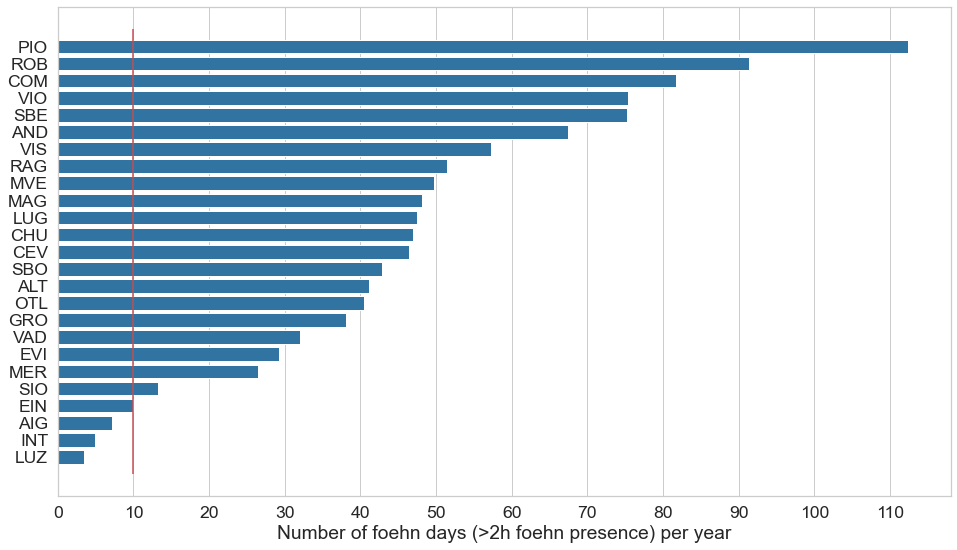

In [88]:
dummy = pd.DataFrame.from_dict(days_of_foehn, orient="index").sort_values(by=0, ascending=False)
dummy = dummy.reset_index()
sns.barplot(y=dummy["index"], x=dummy[0], color="tab:blue")
plt.xlabel("Number of foehn days (>2h foehn presence) per year")
plt.xticks(range(0,120+1,10))
plt.ylabel("")
plt.vlines(10, -1,25, color="r")

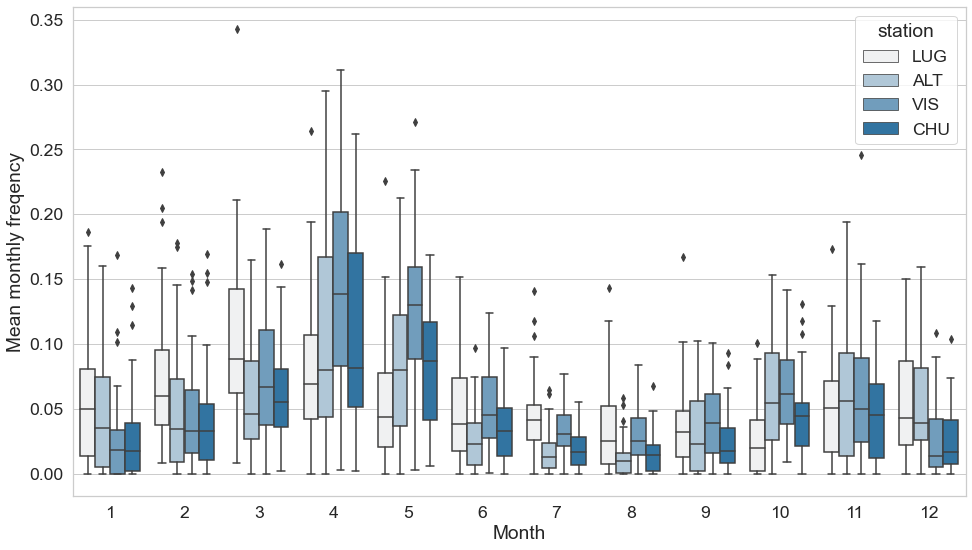

In [7]:


monthly_freqs = pd.DataFrame()

for station in [ "LUG", "ALT", "VIS", "CHU"]:
    
    group = df_foehn[["year", "month", f"{station}_foehn"]].groupby(by=["year", "month"], as_index=False)
    #print(group.min()["month"])
    month= group.min()["month"]

    freq = group.mean()[f"{station}_foehn"]
    #print(freq)
    dummy = pd.DataFrame({"month": month.values, "freq": freq.values})
    dummy["station"] = station
    
    monthly_freqs = pd.concat([monthly_freqs, dummy], axis=0)
    
sns.boxplot(x="month", y="freq", data=monthly_freqs, hue="station", color="tab:blue")
plt.ylabel("Mean monthly freqency")
plt.xlabel("Month")
save_figure(f"BoxplotFoehnFrequencies")
    